<a href="https://colab.research.google.com/github/aaaven/aiarts2020/blob/master/DeepDreaming_with_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepDreaming with Layers


#### author info 

* by Aven Le ZHOU (https://www.aven.cc)
* artMahcines & NYU Shanghai
* aiarts, spring 2020
* https://github.com/artmachines/aiarts2020

#### credits

* Original code implementation from ___Alex Mordvintsev___ [colab link](https://colab.research.google.com/drive/1DWcrN9WXni58MbddvlShX0wF_oeo8W_0)
* adapted by Aven for aiarts 2020 course

#### orginal notes from ___Alex Mordvintsev___
This notebook produces DeepDream images from user-supplied photos using Google's pretrained Inception neural network. It can be used as a starting point for further exploration in visualizing convolutional neural networks.

#### update functions by ___Aven Le ZHOU___
save step by step frames, and the frames into videos
parametric controls on the generative process such as choosing layers, zoom-in scales and video length

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/0-Colab-Assets/deepdream"
image_path = "{}/eye.jpg".format(file_path)
image_contents = open(image_path).read()  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### 1) Set up

In [3]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip
# !wget -nc https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg


from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
# import tensorflow as tf
import tensorflow
import tensorflow.compat.v1 as tf

from __future__ import print_function

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

img0 = sess.run(tf.image.decode_image(image_contents))

# showarray(img0)

# These parameters let us control the strenth of the deepdream.
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

File ‘inception5h.zip’ already there; not retrieving.

Archive:  inception5h.zip


/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### 2) Let's deep dream ! -- Customize your own neural style

You can adjust the sliders to change the strength of the deep dream, and how many scales it is applied over.

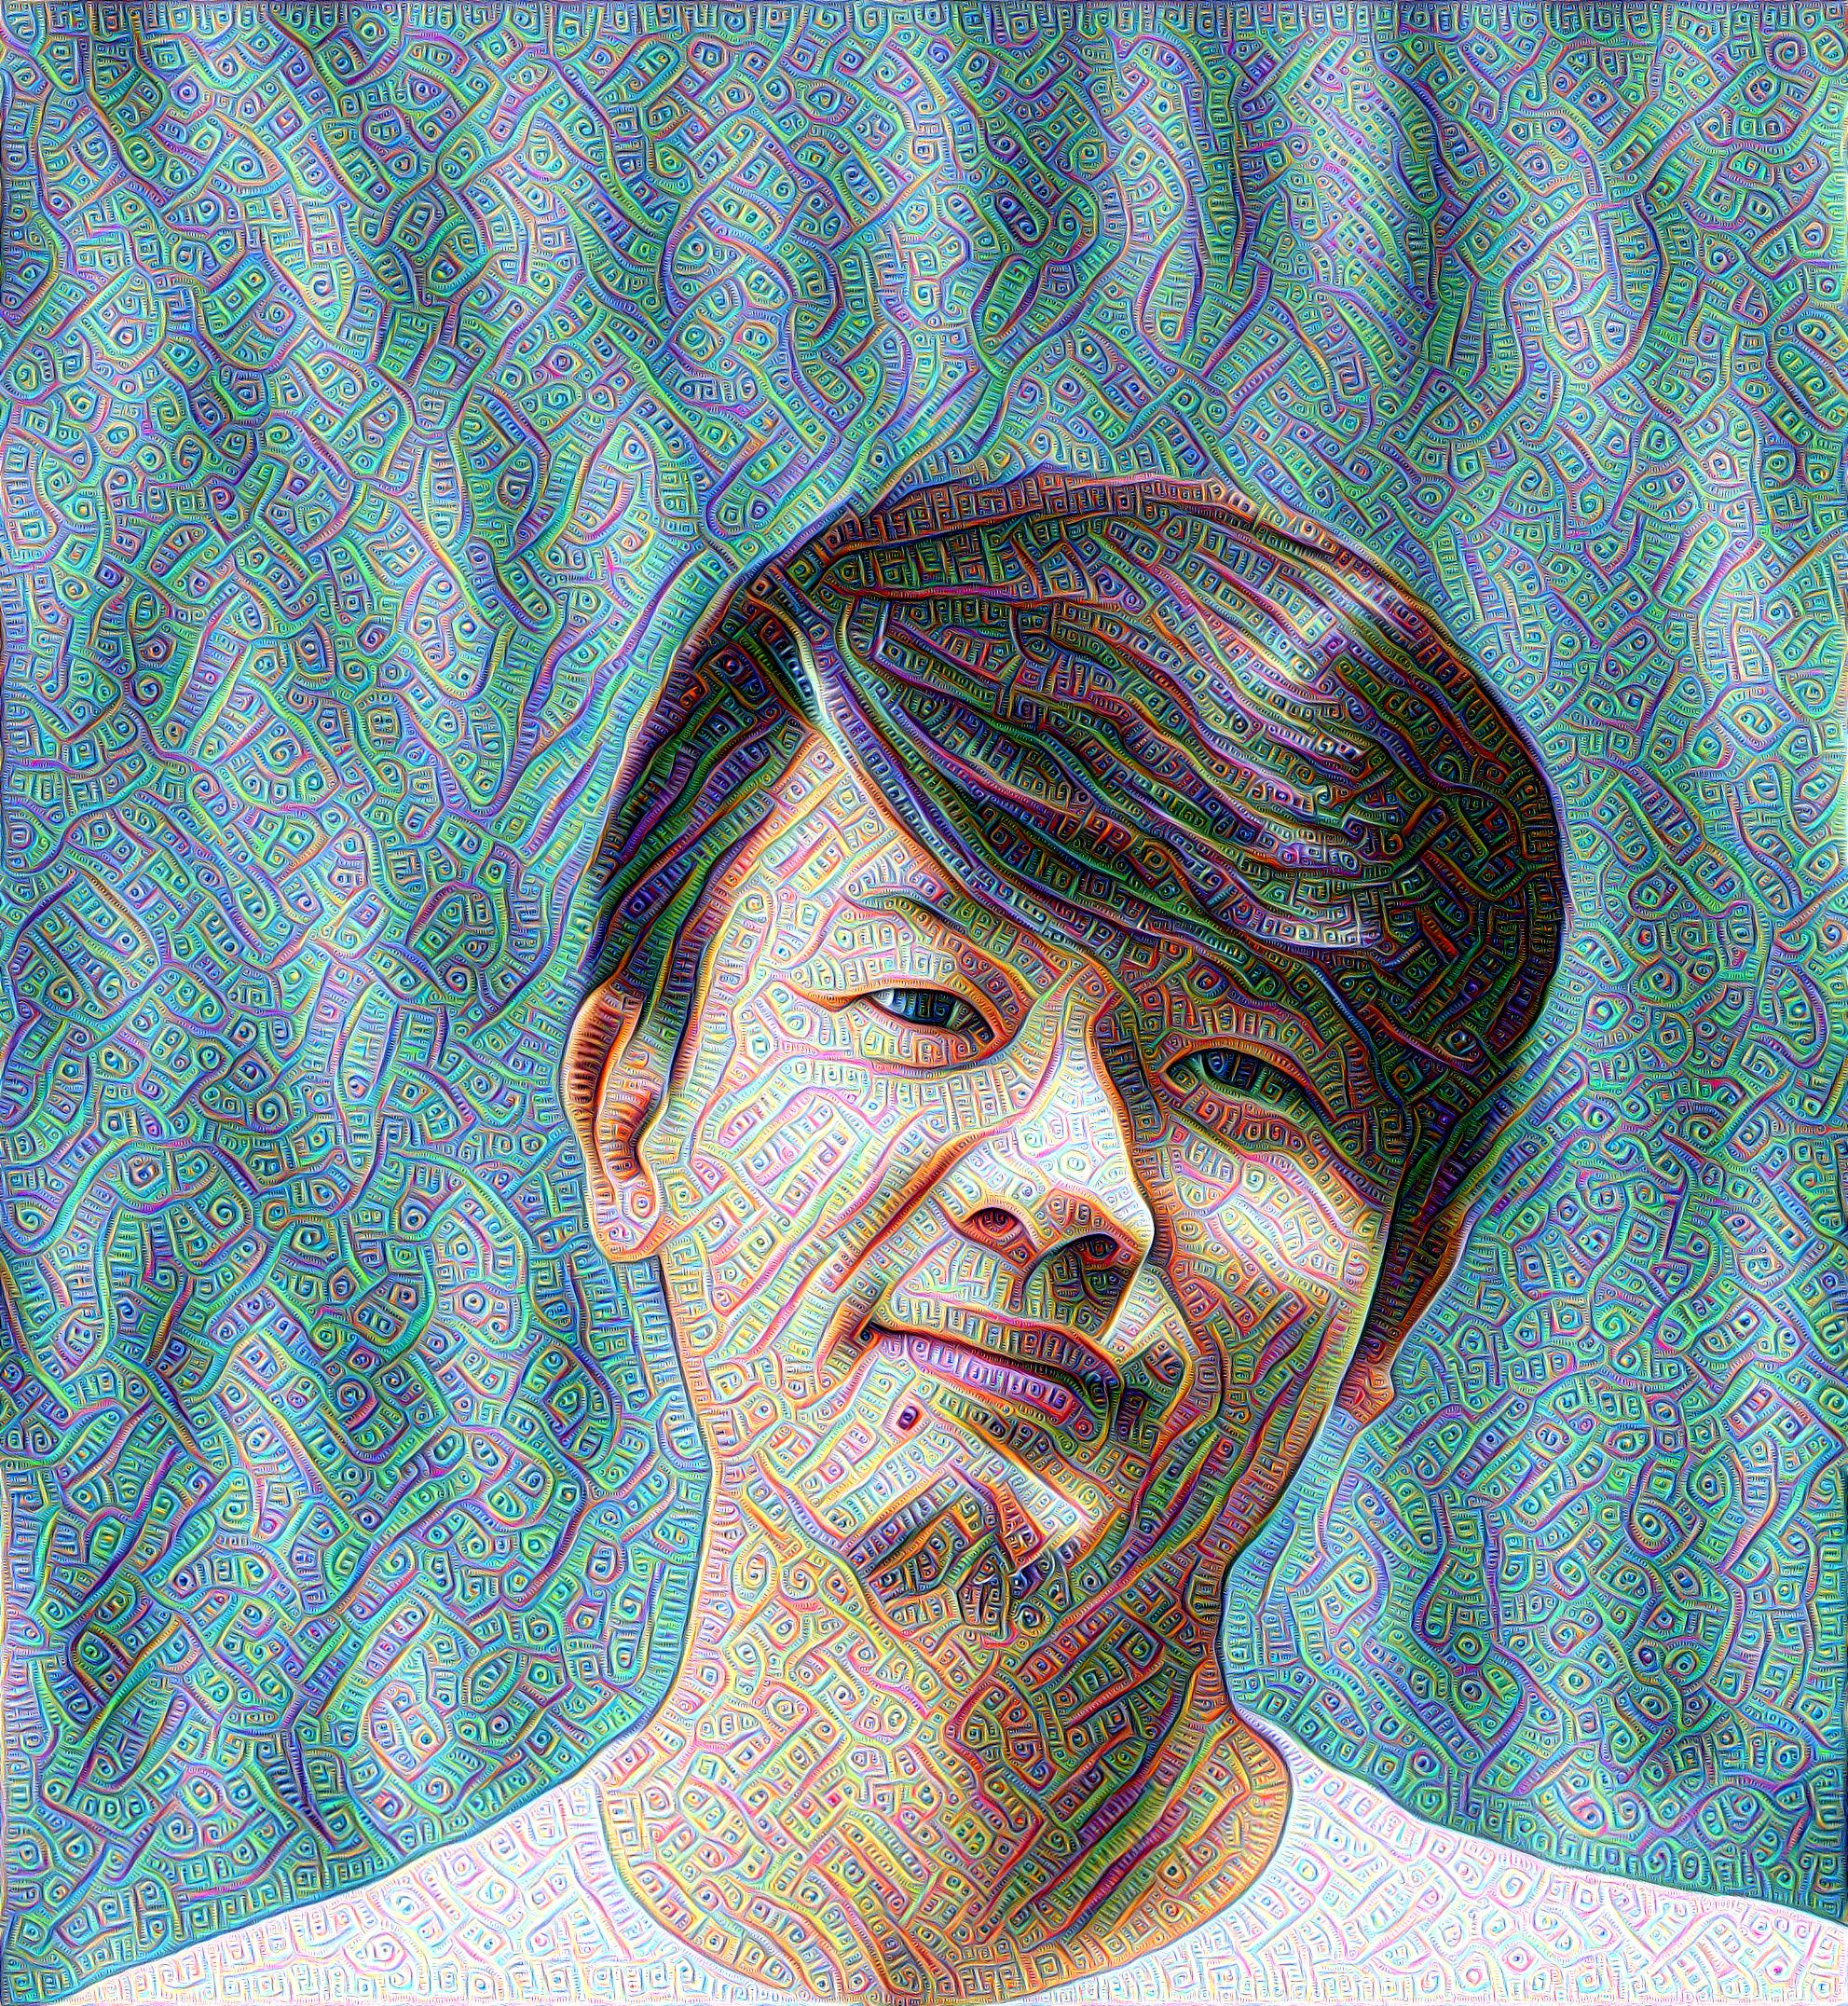

In [4]:
octave_n = 3 #@param {type:"slider", max: 10}
octave_scale = 1.8 #@param {type:"number"}
iter_n = 19 #@param {type:"slider", max: 50}
strength = 540 #@param {type:"slider", max: 1000}
layer = "mixed3a"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

final = render_deepdream(tf.square(T(layer)), img0)


### 3) Zoom in and DeepDream iteratively

Loop/Zoom + deepdream!

In [0]:
dreaming_steps = 4 #@param {type:"slider", max: 512}
zooming_steps = 68 #@param {type:"slider", max: 512}
zoom_factor = 1.4 #@param {type:"number"}

frame = img0
img_y, img_x, _ = img0.shape

clear_output()

# prep video
import cv2
video_name = "{}/deepdream04.mov".format(file_path)
height, width, _ = final.shape
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc('M','J','P','G'), fps=24, frameSize=(width,height))

frame_num = dreaming_steps + zooming_steps
for i in range(frame_num):
  frame = render_deepdream(tf.square(T(layer)), frame, False)
  # clear_output()
  # showarray(frame)
  print("{} out of {} frames done".format(i,frame_num))
  
  # write frames
  a = np.uint8(np.clip(frame, 0, 255))
  b = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)
  video.write(b)

  # update the size / zoom in
  if(i > dreaming_steps - 1):
    newsize = np.int32(np.float32(frame.shape[:2])*zoom_factor)
    frame = resize(frame, newsize)
    frame = frame[(newsize[0]-img_y)//2:(newsize[0]-img_y)//2+img_y,
                  (newsize[1]-img_x)//2:(newsize[1]-img_x)//2+img_x,:]
    a = np.uint8(np.clip(frame, 0, 255))
    b = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)

    # write the last frame, to continue the video
    if(i >= frame_num - 1):
      pick_up = '{}/pick_up.png'.format(file_path)
      cv2.imwrite(pick_up,b)

    video.write(b)
    


cv2.destroyAllWindows()
video.release()

print("{} is ready".format(video_name))  

0 out of 72 frames done
1 out of 72 frames done
2 out of 72 frames done
3 out of 72 frames done
4 out of 72 frames done
5 out of 72 frames done
6 out of 72 frames done
7 out of 72 frames done
8 out of 72 frames done
9 out of 72 frames done
10 out of 72 frames done
11 out of 72 frames done
12 out of 72 frames done
13 out of 72 frames done
14 out of 72 frames done
15 out of 72 frames done
16 out of 72 frames done
17 out of 72 frames done
18 out of 72 frames done
19 out of 72 frames done
20 out of 72 frames done
21 out of 72 frames done
22 out of 72 frames done
23 out of 72 frames done
24 out of 72 frames done
25 out of 72 frames done
26 out of 72 frames done
27 out of 72 frames done
28 out of 72 frames done
29 out of 72 frames done
30 out of 72 frames done
31 out of 72 frames done
32 out of 72 frames done
33 out of 72 frames done
34 out of 72 frames done
35 out of 72 frames done
36 out of 72 frames done
37 out of 72 frames done
38 out of 72 frames done
39 out of 72 frames done
40 out of 

### Further reading for the curious

 *   Original [DeepDream (Inceptionism) blog post](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
 *   [Original DeepDream algorithm](https://github.com/google/deepdream/blob/master/dream.ipynb) with Caffe